In [1]:
# Cell 1: Environment & imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import joblib
import math
import glob
import json

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Cell 2: Set up data directory
# Update this path to where your CMAPSS data files are located
# NOTE: training file 'train_FD002.txt' in your workspace is at
#       c:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\train_FD002.txt
# Adjust DATA_DIR to the parent folder so joins below locate the file correctly.
DATA_DIR = r'C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\backend\data'

# Check if files exist
train_file = os.path.join(DATA_DIR, 'train_FD004.txt')
test_file = os.path.join(DATA_DIR, 'test_FD004.txt')
rul_file = os.path.join(DATA_DIR, 'RUL_FD004.txt')

print(f"Train file exists: {os.path.exists(train_file)}")
print(f"Test file exists: {os.path.exists(test_file)}")
print(f"RUL file exists: {os.path.exists(rul_file)}")

Train file exists: True
Test file exists: True
RUL file exists: True


In [3]:
# Cell 3: Function to read CMAPSS text files (whitespace separated, no header)
def read_cmapss(filepath):
    """
    Read CMAPSS format: 26 columns whitespace separated
    columns: unit, cycle, op_setting_1..3, sensor_1..21
    """
    col_names = (["unit", "cycle",
                  "op_setting_1", "op_setting_2", "op_setting_3"] +
                 [f"s{i}" for i in range(1, 22)])
    df = pd.read_csv(filepath, sep=r"\s+", header=None, names=col_names)
    return df

# Read training data
df_train = read_cmapss(train_file)
print(f"Training data shape: {df_train.shape}")
print(f"Columns: {list(df_train.columns)}")
print(f"\nFirst few rows:")
print(df_train.head())

Training data shape: (61249, 26)
Columns: ['unit', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']

First few rows:
   unit  cycle  op_setting_1  op_setting_2  op_setting_3      s1      s2  \
0     1      1       42.0049        0.8400         100.0  445.00  549.68   
1     1      2       20.0020        0.7002         100.0  491.19  606.07   
2     1      3       42.0038        0.8409         100.0  445.00  548.95   
3     1      4       42.0000        0.8400         100.0  445.00  548.70   
4     1      5       25.0063        0.6207          60.0  462.54  536.10   

        s3       s4    s5  ...     s12      s13      s14      s15   s16  s17  \
0  1343.43  1112.93  3.91  ...  129.78  2387.99  8074.83   9.3335  0.02  330   
1  1477.61  1237.50  9.35  ...  312.59  2387.73  8046.13   9.1913  0.02  361   
2  1343.12  1117.05  3.91  ...  129.62  

In [4]:
# Cell 4: Create RUL (Remaining Useful Life) labels for training data
def add_rul_train(df):
    """
    For each unit, RUL = max_cycle_for_unit - current_cycle
    """
    df = df.copy()
    max_cycle = df.groupby("unit")["cycle"].max().reset_index()
    max_cycle.columns = ["unit", "max_cycle"]
    df = df.merge(max_cycle, on="unit", how="left")
    df["RUL"] = df["max_cycle"] - df["cycle"]
    df.drop("max_cycle", axis=1, inplace=True)
    return df

# Add RUL to training data
df_train = add_rul_train(df_train)
print(f"Training data with RUL shape: {df_train.shape}")
print(f"RUL statistics:")
print(df_train["RUL"].describe())
print(f"\nNumber of unique units: {df_train['unit'].nunique()}")

Training data with RUL shape: (61249, 27)
RUL statistics:
count    61249.000000
mean       133.311417
std         89.783389
min          0.000000
25%         61.000000
50%        122.000000
75%        190.000000
max        542.000000
Name: RUL, dtype: float64

Number of unique units: 249


In [5]:
# Cell 5: Data preprocessing - normalize sensors and cap RUL
def preprocess_df(df, cap_rul=125, scaler=None, fit_scaler=True):
    """
    Normalize sensor and operational setting columns.
    Cap RUL at a maximum value.
    """
    df = df.copy()
    
    # Auto-detect sensor and operational setting columns
    sensor_cols = [c for c in df.columns if c.startswith('s') or c.startswith('op_setting')]
    
    # Cap RUL
    df["RUL_capped"] = df["RUL"].clip(upper=cap_rul)
    
    # Fit scaler if not provided
    if scaler is None and fit_scaler:
        scaler = StandardScaler()
        scaler.fit(df[sensor_cols])
    
    # Apply scaling
    if scaler is not None:
        df[sensor_cols] = scaler.transform(df[sensor_cols])
    
    return df, scaler, sensor_cols

# Apply preprocessing
df_train_pre, scaler, sensor_cols = preprocess_df(df_train, cap_rul=125)
print(f"Sensor columns ({len(sensor_cols)}): {sensor_cols}")
print(f"Preprocessed data shape: {df_train_pre.shape}")
print(f"RUL_capped statistics:")
print(df_train_pre["RUL_capped"].describe())

Sensor columns (24): ['op_setting_1', 'op_setting_2', 'op_setting_3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
Preprocessed data shape: (61249, 28)
RUL_capped statistics:
count    61249.000000
mean        92.985192
std         40.665112
min          0.000000
25%         61.000000
50%        122.000000
75%        125.000000
max        125.000000
Name: RUL_capped, dtype: float64


In [6]:
# Cell 6: Create sequences for GRU model
def generate_sequences(df, seq_len=50, sensor_cols=None, label_col="RUL_capped", step=1):
    """
    Create sliding windows of sequences for each unit.
    Each sequence predicts RUL at the last timestep.
    """
    Xs = []
    ys = []
    units = sorted(df["unit"].unique())
    
    for u in units:
        tmp = df[df["unit"] == u].sort_values("cycle")
        data = tmp[sensor_cols].values
        labels = tmp[label_col].values
        n_cycles = data.shape[0]
        
        # Skip units with fewer cycles than sequence length
        if n_cycles < seq_len:
            continue
        
        # Create sliding windows
        for start in range(0, n_cycles - seq_len + 1, step):
            end = start + seq_len
            Xs.append(data[start:end])
            ys.append(labels[end - 1])
    
    X = np.array(Xs)
    y = np.array(ys)
    return X, y

# Generate sequences
SEQ_LEN = 50
X, y = generate_sequences(df_train_pre, seq_len=SEQ_LEN, sensor_cols=sensor_cols)
print(f"Sequences generated:")
print(f"X shape: {X.shape} (samples, sequence_length, features)")
print(f"y shape: {y.shape}")
print(f"y statistics: min={y.min():.2f}, max={y.max():.2f}, mean={y.mean():.2f}")

Sequences generated:
X shape: (49048, 50, 24) (samples, sequence_length, features)
y shape: (49048,)
y statistics: min=0.00, max=125.00, mean=85.19


In [7]:
# Cell 7: Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42, shuffle=True
)
print(f"Train set: X={X_train.shape}, y={y_train.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}")

Train set: X=(41690, 50, 24), y=(41690,)
Validation set: X=(7358, 50, 24), y=(7358,)


In [8]:
# Cell 8: Build GRU model
def build_gru_model(input_shape, units=64, dropout=0.2):
    """Build a GRU-based neural network for RUL prediction."""
    model = Sequential()
    model.add(GRU(units, input_shape=input_shape, return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(1, activation="linear"))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=["mae"]
    )
    return model

model = build_gru_model((SEQ_LEN, len(sensor_cols)), units=128, dropout=0.3)
print("Model created successfully!")
model.summary()

Model created successfully!


c:\Users\Sneha\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128)            │        59,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,969 (265.50 KB)

 Trainable params: 67,713 (264.50 KB)

 Non-trainable params: 256 (1.00 KB)

In [9]:
# Cell 9: Train the model
EPOCHS = 60
BATCH_SIZE = 128

checkpoint_path = r'C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd004.h5'
scaler_path = r'C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\scaler_fd004.joblib'

callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1)
]

print("Starting training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=2
)

# Save the scaler
joblib.dump(scaler, scaler_path)
print(f"Model saved to: {checkpoint_path}")
print(f"Scaler saved to: {scaler_path}")

Starting training...
Epoch 1/60

Epoch 1: val_loss improved from inf to 685.95905, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd004.h5


326/326 - 32s - 98ms/step - loss: 2414.5229 - mae: 36.0898 - val_loss: 685.9590 - val_mae: 20.2836
Epoch 2/60

Epoch 2: val_loss did not improve from 685.95905
326/326 - 26s - 79ms/step - loss: 567.8560 - mae: 18.5669 - val_loss: 724.0528 - val_mae: 19.7082
Epoch 3/60

Epoch 3: val_loss improved from 685.95905 to 434.18848, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd004.h5


326/326 - 26s - 80ms/step - loss: 527.3950 - mae: 17.7558 - val_loss: 434.1885 - val_mae: 15.6537
Epoch 4/60

Epoch 4: val_loss improved from 434.18848 to 333.95438, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd004.h5


326/326 - 26s - 79ms/step - loss: 462.7540 - mae: 16.5334 - val_loss: 333.9544 - val_mae: 13.9875
Epoch 5/60

Epoch 5: val_loss improved from 333.95438 to 319.98898, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd004.h5


326/326 - 26s - 81ms/step - loss: 384.2651 - mae: 14.9802 - val_loss: 319.9890 - val_mae: 12.9042
Epoch 6/60

Epoch 6: val_loss did not improve from 319.98898
326/326 - 26s - 79ms/step - loss: 338.0705 - mae: 13.9733 - val_loss: 329.3593 - val_mae: 13.0515
Epoch 7/60

Epoch 7: val_loss improved from 319.98898 to 288.75754, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd004.h5


326/326 - 26s - 80ms/step - loss: 320.2836 - mae: 13.5460 - val_loss: 288.7575 - val_mae: 12.6460
Epoch 8/60

Epoch 8: val_loss improved from 288.75754 to 263.87164, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd004.h5


326/326 - 26s - 79ms/step - loss: 298.2687 - mae: 13.0703 - val_loss: 263.8716 - val_mae: 11.1485
Epoch 9/60

Epoch 9: val_loss improved from 263.87164 to 232.40561, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd004.h5


326/326 - 26s - 80ms/step - loss: 294.4475 - mae: 12.9610 - val_loss: 232.4056 - val_mae: 10.3476
Epoch 10/60

Epoch 10: val_loss improved from 232.40561 to 229.27208, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd004.h5


326/326 - 25s - 78ms/step - loss: 272.2504 - mae: 12.4307 - val_loss: 229.2721 - val_mae: 11.1854
Epoch 11/60

Epoch 11: val_loss improved from 229.27208 to 201.23909, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd004.h5


326/326 - 26s - 79ms/step - loss: 273.9715 - mae: 12.4373 - val_loss: 201.2391 - val_mae: 9.9748
Epoch 12/60

Epoch 12: val_loss improved from 201.23909 to 196.57661, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd004.h5


326/326 - 26s - 80ms/step - loss: 255.3000 - mae: 12.0330 - val_loss: 196.5766 - val_mae: 9.9009
Epoch 13/60

Epoch 13: val_loss improved from 196.57661 to 182.57796, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd004.h5


326/326 - 26s - 79ms/step - loss: 241.2580 - mae: 11.7087 - val_loss: 182.5780 - val_mae: 9.4545
Epoch 14/60

Epoch 14: val_loss did not improve from 182.57796
326/326 - 26s - 80ms/step - loss: 220.0729 - mae: 11.1590 - val_loss: 210.4091 - val_mae: 10.8690
Epoch 15/60

Epoch 15: val_loss did not improve from 182.57796
326/326 - 27s - 84ms/step - loss: 207.7681 - mae: 10.8304 - val_loss: 248.2867 - val_mae: 11.7352
Epoch 16/60

Epoch 16: val_loss improved from 182.57796 to 160.09712, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd004.h5


326/326 - 27s - 82ms/step - loss: 194.2263 - mae: 10.4992 - val_loss: 160.0971 - val_mae: 8.6610
Epoch 17/60

Epoch 17: val_loss improved from 160.09712 to 134.59024, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd004.h5


326/326 - 45s - 138ms/step - loss: 176.2482 - mae: 10.0087 - val_loss: 134.5902 - val_mae: 8.3507
Epoch 18/60

Epoch 18: val_loss improved from 134.59024 to 134.16264, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd004.h5


326/326 - 29s - 89ms/step - loss: 165.6478 - mae: 9.6875 - val_loss: 134.1626 - val_mae: 8.5922
Epoch 19/60

Epoch 19: val_loss improved from 134.16264 to 123.94086, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd004.h5


326/326 - 42s - 128ms/step - loss: 148.1884 - mae: 9.2373 - val_loss: 123.9409 - val_mae: 8.5242
Epoch 20/60

Epoch 20: val_loss did not improve from 123.94086
326/326 - 127s - 391ms/step - loss: 142.7166 - mae: 9.0843 - val_loss: 140.7956 - val_mae: 9.0589
Epoch 21/60

Epoch 21: val_loss improved from 123.94086 to 74.95663, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd004.h5


326/326 - 32s - 99ms/step - loss: 133.0450 - mae: 8.7988 - val_loss: 74.9566 - val_mae: 5.9325
Epoch 22/60

Epoch 22: val_loss did not improve from 74.95663
326/326 - 55s - 168ms/step - loss: 120.8391 - mae: 8.4189 - val_loss: 79.6596 - val_mae: 6.4910
Epoch 23/60

Epoch 23: val_loss improved from 74.95663 to 63.39820, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd004.h5


326/326 - 28s - 87ms/step - loss: 112.4927 - mae: 8.1640 - val_loss: 63.3982 - val_mae: 5.8733
Epoch 24/60

Epoch 24: val_loss did not improve from 63.39820
326/326 - 27s - 83ms/step - loss: 107.3807 - mae: 7.9877 - val_loss: 128.9536 - val_mae: 8.7955
Epoch 25/60

Epoch 25: val_loss did not improve from 63.39820
326/326 - 29s - 89ms/step - loss: 100.3397 - mae: 7.7291 - val_loss: 73.6321 - val_mae: 6.1979
Epoch 26/60

Epoch 26: val_loss improved from 63.39820 to 59.64714, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd004.h5


326/326 - 29s - 89ms/step - loss: 96.8822 - mae: 7.5707 - val_loss: 59.6471 - val_mae: 5.8070
Epoch 27/60

Epoch 27: val_loss improved from 59.64714 to 43.20897, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd004.h5


326/326 - 54s - 165ms/step - loss: 89.3998 - mae: 7.3192 - val_loss: 43.2090 - val_mae: 4.9946
Epoch 28/60

Epoch 28: val_loss improved from 43.20897 to 41.71421, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd004.h5


326/326 - 48s - 148ms/step - loss: 86.0509 - mae: 7.1883 - val_loss: 41.7142 - val_mae: 4.7688
Epoch 29/60

Epoch 29: val_loss improved from 41.71421 to 33.44701, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd004.h5


326/326 - 68s - 210ms/step - loss: 80.7008 - mae: 6.9527 - val_loss: 33.4470 - val_mae: 4.2744
Epoch 30/60

Epoch 30: val_loss did not improve from 33.44701
326/326 - 28s - 85ms/step - loss: 81.8167 - mae: 6.9790 - val_loss: 38.1852 - val_mae: 4.8890
Epoch 31/60

Epoch 31: val_loss did not improve from 33.44701
326/326 - 38s - 118ms/step - loss: 75.9792 - mae: 6.7255 - val_loss: 47.1181 - val_mae: 4.8246
Epoch 32/60

Epoch 32: val_loss did not improve from 33.44701
326/326 - 27s - 82ms/step - loss: 72.4505 - mae: 6.5672 - val_loss: 97.9323 - val_mae: 7.8250
Epoch 33/60

Epoch 33: val_loss did not improve from 33.44701
326/326 - 26s - 81ms/step - loss: 68.7433 - mae: 6.4108 - val_loss: 39.1184 - val_mae: 4.7126
Epoch 34/60

Epoch 34: val_loss did not improve from 33.44701
326/326 - 26s - 80ms/step - loss: 70.0438 - mae: 6.4711 - val_loss: 48.7256 - val_mae: 5.4985
Epoch 35/60

Epoch 35: val_loss did not improve from 33.44701
326/326 - 26s - 80ms/step - loss: 64.5781 - mae: 6.2347 - val_

326/326 - 54s - 167ms/step - loss: 61.0423 - mae: 6.0604 - val_loss: 30.5193 - val_mae: 4.3059
Epoch 38/60

Epoch 38: val_loss improved from 30.51931 to 21.78183, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd004.h5


326/326 - 25s - 78ms/step - loss: 60.9760 - mae: 6.0464 - val_loss: 21.7818 - val_mae: 3.5720
Epoch 39/60

Epoch 39: val_loss did not improve from 21.78183
326/326 - 27s - 82ms/step - loss: 56.3269 - mae: 5.8059 - val_loss: 51.3128 - val_mae: 5.8180
Epoch 40/60

Epoch 40: val_loss did not improve from 21.78183
326/326 - 27s - 84ms/step - loss: 55.2237 - mae: 5.7592 - val_loss: 25.0372 - val_mae: 3.7602
Epoch 41/60

Epoch 41: val_loss improved from 21.78183 to 18.50667, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd004.h5


326/326 - 28s - 86ms/step - loss: 52.5014 - mae: 5.6099 - val_loss: 18.5067 - val_mae: 3.1028
Epoch 42/60

Epoch 42: val_loss did not improve from 18.50667
326/326 - 27s - 83ms/step - loss: 53.6969 - mae: 5.6842 - val_loss: 37.2929 - val_mae: 4.8166
Epoch 43/60

Epoch 43: val_loss did not improve from 18.50667
326/326 - 26s - 80ms/step - loss: 49.3246 - mae: 5.4389 - val_loss: 21.4007 - val_mae: 3.5086
Epoch 44/60

Epoch 44: val_loss improved from 18.50667 to 16.94081, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd004.h5


326/326 - 28s - 84ms/step - loss: 47.7826 - mae: 5.3516 - val_loss: 16.9408 - val_mae: 2.9997
Epoch 45/60

Epoch 45: val_loss did not improve from 16.94081
326/326 - 27s - 83ms/step - loss: 47.9887 - mae: 5.3726 - val_loss: 27.2900 - val_mae: 3.6188
Epoch 46/60

Epoch 46: val_loss improved from 16.94081 to 16.48310, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd004.h5


326/326 - 28s - 85ms/step - loss: 44.4065 - mae: 5.1738 - val_loss: 16.4831 - val_mae: 3.1943
Epoch 47/60

Epoch 47: val_loss did not improve from 16.48310
326/326 - 28s - 85ms/step - loss: 46.0714 - mae: 5.2725 - val_loss: 19.8201 - val_mae: 3.5540
Epoch 48/60

Epoch 48: val_loss did not improve from 16.48310
326/326 - 28s - 85ms/step - loss: 42.8210 - mae: 5.0832 - val_loss: 18.9760 - val_mae: 3.3809
Epoch 49/60

Epoch 49: val_loss improved from 16.48310 to 15.78665, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd004.h5


326/326 - 30s - 91ms/step - loss: 40.2359 - mae: 4.9394 - val_loss: 15.7867 - val_mae: 3.0173
Epoch 50/60

Epoch 50: val_loss did not improve from 15.78665
326/326 - 28s - 87ms/step - loss: 39.0420 - mae: 4.8744 - val_loss: 20.1197 - val_mae: 3.4624
Epoch 51/60

Epoch 51: val_loss did not improve from 15.78665
326/326 - 29s - 87ms/step - loss: 36.4123 - mae: 4.7009 - val_loss: 19.6586 - val_mae: 3.1566
Epoch 52/60

Epoch 52: val_loss did not improve from 15.78665
326/326 - 30s - 92ms/step - loss: 36.9210 - mae: 4.7097 - val_loss: 24.6955 - val_mae: 3.9292
Epoch 53/60

Epoch 53: val_loss did not improve from 15.78665
326/326 - 31s - 96ms/step - loss: 35.2050 - mae: 4.6293 - val_loss: 22.2249 - val_mae: 3.2659
Epoch 54/60

Epoch 54: val_loss did not improve from 15.78665
326/326 - 30s - 93ms/step - loss: 34.4072 - mae: 4.5740 - val_loss: 19.3611 - val_mae: 3.0167
Epoch 55/60

Epoch 55: val_loss did not improve from 15.78665
326/326 - 30s - 91ms/step - loss: 32.2080 - mae: 4.4230 - val_lo

326/326 - 40s - 122ms/step - loss: 33.0405 - mae: 4.4723 - val_loss: 11.8554 - val_mae: 2.5387
Epoch 57/60

Epoch 57: val_loss improved from 11.85540 to 10.74200, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd004.h5


326/326 - 36s - 111ms/step - loss: 32.2718 - mae: 4.4121 - val_loss: 10.7420 - val_mae: 2.4534
Epoch 58/60

Epoch 58: val_loss did not improve from 10.74200
326/326 - 31s - 94ms/step - loss: 28.9518 - mae: 4.2097 - val_loss: 33.6142 - val_mae: 4.1651
Epoch 59/60

Epoch 59: val_loss did not improve from 10.74200
326/326 - 30s - 91ms/step - loss: 27.1764 - mae: 4.0765 - val_loss: 15.4990 - val_mae: 3.1723
Epoch 60/60

Epoch 60: val_loss did not improve from 10.74200
326/326 - 30s - 93ms/step - loss: 26.4565 - mae: 4.0328 - val_loss: 11.9844 - val_mae: 2.6406
Restoring model weights from the end of the best epoch: 57.
Model saved to: C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd004.h5
Scaler saved to: C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\scaler_fd004.joblib


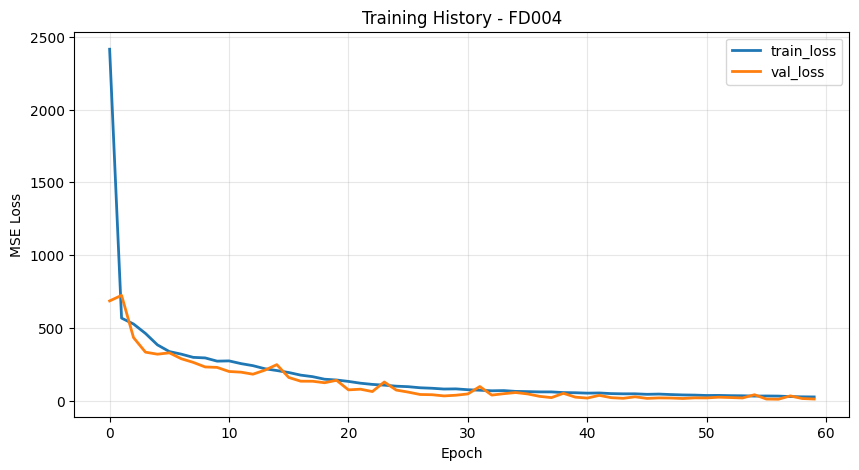

In [16]:
# Cell 10: Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="train_loss", linewidth=2)
plt.plot(history.history["val_loss"], label="val_loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training History - FD004")
plt.grid(True, alpha=0.3)
plt.show()

In [17]:
# Cell 11: Evaluate on validation set
y_val_pred = model.predict(X_val, verbose=0).ravel()
rmse_val = math.sqrt(mean_squared_error(y_val, y_val_pred))
mae_val = np.mean(np.abs(y_val - y_val_pred))

print(f"Validation RMSE: {rmse_val:.4f}")
print(f"Validation MAE: {mae_val:.4f}")

Validation RMSE: 3.2775
Validation MAE: 2.4534


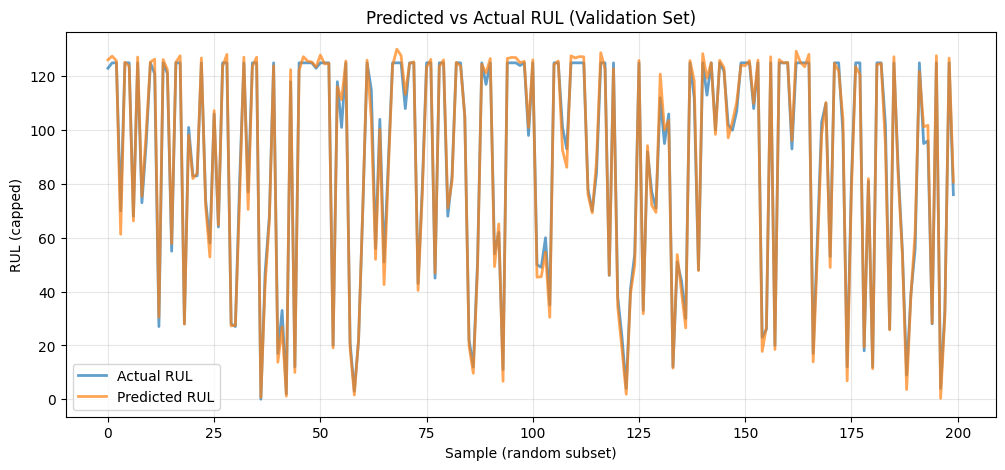

In [18]:
# Cell 12: Predicted vs Actual plot (random sample)
sample_size = min(200, len(y_val))
idx = np.random.choice(len(y_val), size=sample_size, replace=False)

plt.figure(figsize=(12, 5))
plt.plot(y_val[idx], label="Actual RUL", linewidth=2, alpha=0.7)
plt.plot(y_val_pred[idx], label="Predicted RUL", linewidth=2, alpha=0.7)
plt.xlabel("Sample (random subset)")
plt.ylabel("RUL (capped)")
plt.legend()
plt.title("Predicted vs Actual RUL (Validation Set)")
plt.grid(True, alpha=0.3)
plt.show()

In [22]:
# Cell 13: Test set evaluation (if test files exist)
if os.path.exists(test_file) and os.path.exists(rul_file):
    print("Loading test data...")
    
    # Read test data
    df_test_raw = read_cmapss(test_file)
    
    # Preprocess test data using the fitted scaler
    df_test_scaled = df_test_raw.copy()
    df_test_scaled[sensor_cols] = scaler.transform(df_test_raw[sensor_cols].values)
    
    # Build test sequences: use last SEQ_LEN cycles for each unit
    X_test = []
    test_units = sorted(df_test_scaled["unit"].unique())
    
    for u in test_units:
        tmp = df_test_scaled[df_test_scaled["unit"] == u].sort_values("cycle")
        arr = tmp[sensor_cols].values
        
        if arr.shape[0] >= SEQ_LEN:
            X_test.append(arr[-SEQ_LEN:])
        else:
            # Pad at front if not enough cycles
            pad_n = SEQ_LEN - arr.shape[0]
            pad = np.tile(arr[0], (pad_n, 1))
            X_test.append(np.vstack([pad, arr]))
    
    X_test = np.array(X_test)
    
    # Load true RUL values
    y_test_true = pd.read_csv(rul_file, sep=r"\s+", header=None).values.ravel()
    
    # Cap RUL the same way as training
    CAP_RUL = 125
    y_test_true = np.clip(y_test_true, a_min=None, a_max=CAP_RUL)
    
    # Make predictions
    y_test_pred = model.predict(X_test, verbose=0).ravel()
    
    # Evaluate
    rmse_test = math.sqrt(mean_squared_error(y_test_true, y_test_pred))
    mae_test = np.mean(np.abs(y_test_true - y_test_pred))
    
    print(f"\nTest RMSE (capped at {CAP_RUL}): {rmse_test:.4f}")
    print(f"Test MAE: {mae_test:.4f}")
    print(f"Test samples: {len(y_test_true)}")
else:
    print("Test files not found!")

Loading test data...


c:\Users\Sneha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Test RMSE (capped at 125): 20.5783
Test MAE: 14.8013
Test samples: 248


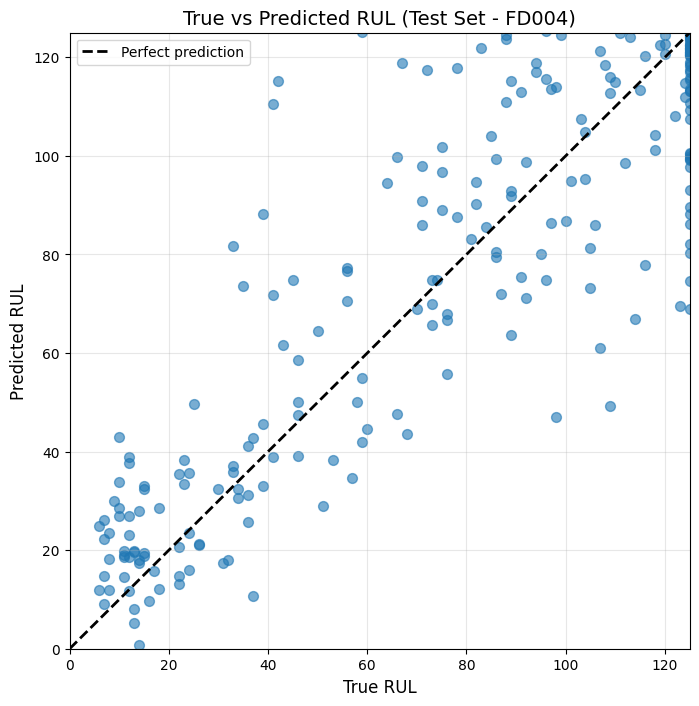

In [20]:
# Cell 14: Test set scatter plot (True vs Predicted)
if os.path.exists(test_file) and os.path.exists(rul_file):
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test_true, y_test_pred, alpha=0.6, s=50)
    plt.xlabel("True RUL", fontsize=12)
    plt.ylabel("Predicted RUL", fontsize=12)
    plt.title("True vs Predicted RUL (Test Set - FD004)", fontsize=14)
    plt.plot([0, CAP_RUL], [0, CAP_RUL], "k--", linewidth=2, label="Perfect prediction")
    plt.xlim(0, CAP_RUL)
    plt.ylim(0, CAP_RUL)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Test files not available for visualization")

In [21]:
# Cell 15: Health status alerts for test units
if os.path.exists(test_file) and os.path.exists(rul_file):
    WARNING_THRESHOLD = 30
    CRITICAL_THRESHOLD = 10
    
    def get_alert_status(rul_value):
        """Determine health status based on RUL prediction."""
        if rul_value <= CRITICAL_THRESHOLD:
            return "CRITICAL ⚠️"
        elif rul_value <= WARNING_THRESHOLD:
            return "WARNING ⚠"
        else:
            return "NORMAL ✓"
    
    print("\n" + "="*80)
    print("HEALTH STATUS ALERTS FOR TEST UNITS (FD004)")
    print("="*80)
    print(f"{'Unit':<8} {'True RUL':<12} {'Pred RUL':<12} {'Error':<12} {'Status':<20}")
    print("-"*80)
    
    for i in range(len(test_units)):
        error = abs(y_test_true[i] - y_test_pred[i])
        status = get_alert_status(y_test_pred[i])
        print(f"{test_units[i]:<8} {y_test_true[i]:<12.2f} {y_test_pred[i]:<12.2f} {error:<12.2f} {status:<20}")
    
    print("="*80)
else:
    print("Test files not available for alerts")


HEALTH STATUS ALERTS FOR TEST UNITS (FD004)
Unit     True RUL     Pred RUL     Error        Status              
--------------------------------------------------------------------------------
1        22.00        35.53        13.53        NORMAL ✓            
2        39.00        88.12        49.12        NORMAL ✓            
3        107.00       121.35       14.35        NORMAL ✓            
4        75.00        89.06        14.06        NORMAL ✓            
5        125.00       113.20       11.80        NORMAL ✓            
6        78.00        117.77       39.77        NORMAL ✓            
7        94.00        118.90       24.90        NORMAL ✓            
8        14.00        0.70         13.30        CRITICAL ⚠️         
9        99.00        124.47       25.47        NORMAL ✓            
10       125.00       107.45       17.55        NORMAL ✓            
11       125.00       99.10        25.90        NORMAL ✓            
12       7.00         26.13        19.13      